In [1]:
# import packages [RUN THIS]
import numpy as np
import pandas as pd
from bertopic import BERTopic
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import math
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.metrics import silhouette_score

c:\Users\UPPL - 01\Downloads\Anaconda-coding\envs\bert-20\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import dataset
df = pd.read_csv("../datasets/news_dataset_content_cleaned.csv")
df.head()

,outlet,article_text,content_sentence,content_words
0,CBC.ca,Tij Iginla doesn't shy away from his famous la...,tij iginla shy away famous last name instead e...,"['tij', 'iginla', 'shy', 'away', 'famous', 'la..."
1,CBC.ca,This week on The Sunday Magazine with host Piy...,week sunday magazine host piya chattopadhyay s...,"['week', 'sunday', 'magazine', 'host', 'piya',..."
2,CBC News,An Ontario Conservative MP's use of ChatGPT to...,ontario conservative mp use chatgpt share inco...,"['ontario', 'conservative', 'mp', 'use', 'chat..."
3,CBC.ca,"When it comes to the study of sports, a man's ...",come study sport man body long considered defa...,"['come', 'study', 'sport', 'man', 'body', 'lon..."
4,CBC.ca,"To wrap up the 48th season of Quirks & Quarks,...",wrap th season quirk quark got another edition...,"['wrap', 'th', 'season', 'quirk', 'quark', 'go..."


In [31]:
# [RUN THIS]
lda_topics = pd.read_csv("../datasets/articles_with_dominant_topic_lda.csv")
lda_topics.head()

,article_text,outlet,nlp_label,nlp-image_label,dominant_topic_lda
0,Tij Iginla doesn't shy away from his famous la...,CBC.ca,Likely to be Bias,Likely to be Unbiased,2
1,This week on The Sunday Magazine with host Piy...,CBC.ca,Likely to be Bias,Likely to be Unbiased,2
2,An Ontario Conservative MP's use of ChatGPT to...,CBC News,Likely to be Bias,Likely to be Bias,1
3,"When it comes to the study of sports, a man's ...",CBC.ca,Likely to be Unbiased,Likely to be Unbiased,1
4,"To wrap up the 48th season of Quirks & Quarks,...",CBC.ca,Likely to be Bias,Likely to be Unbiased,11


In [6]:
# additional pre-processing
custom_stopwords = set([
    "could", "should", "would", "may", "might", "said", "year", "just", "many", "even", 
    "still", "back",  "day", "week", "month", "use", "give", "take", "since", "much", 
    "got", "whether", "look", "always", "let", "yet", "asked", "across", "cooky", "cookie",
    "cookies", "setting", "settings", "site", "sites", "website", "websites", "web", "page",
    "browser", "privacy", "advertisement", "advertisements", "ad", "ads", "clear", "real", 
    "associated", "th"])

# Uncomment this line when running the code for the first time after importing csv
# df['content_words'] = df['content_words'].apply(eval)

df['content_words'] = df['content_words'].apply(lambda x: [word for word in x if word not in custom_stopwords])

df["content_sentence"] = df["content_words"].apply(lambda x: " ".join(x))

# drop all null values
# df = df["headline_sentence"].dropna()

df.head()

,outlet,article_text,content_sentence,content_words
0,CBC.ca,Tij Iginla doesn't shy away from his famous la...,tij iginla shy away famous last name instead e...,"[tij, iginla, shy, away, famous, last, name, i..."
1,CBC.ca,This week on The Sunday Magazine with host Piy...,sunday magazine host piya chattopadhyay sunday...,"[sunday, magazine, host, piya, chattopadhyay, ..."
2,CBC News,An Ontario Conservative MP's use of ChatGPT to...,ontario conservative mp chatgpt share incorrec...,"[ontario, conservative, mp, chatgpt, share, in..."
3,CBC.ca,"When it comes to the study of sports, a man's ...",come study sport man body long considered defa...,"[come, study, sport, man, body, long, consider..."
4,CBC.ca,"To wrap up the 48th season of Quirks & Quarks,...",wrap season quirk quark another edition listen...,"[wrap, season, quirk, quark, another, edition,..."


In [9]:
len(df)

40945

In [7]:
# initialize BERTopic
topic_model_i = BERTopic(language="english", calculate_probabilities=True, nr_topics="auto", min_topic_size=50, top_n_words=5)

# fit BERTopic
topics, probs = topic_model_i.fit_transform(df['content_sentence'])

# Print the top topics
print(topic_model_i.get_topic_info())

KeyboardInterrupt: 

In [14]:
topic_model_i.save("bertopic_model_content")

2025-03-30 16:04:43,051 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


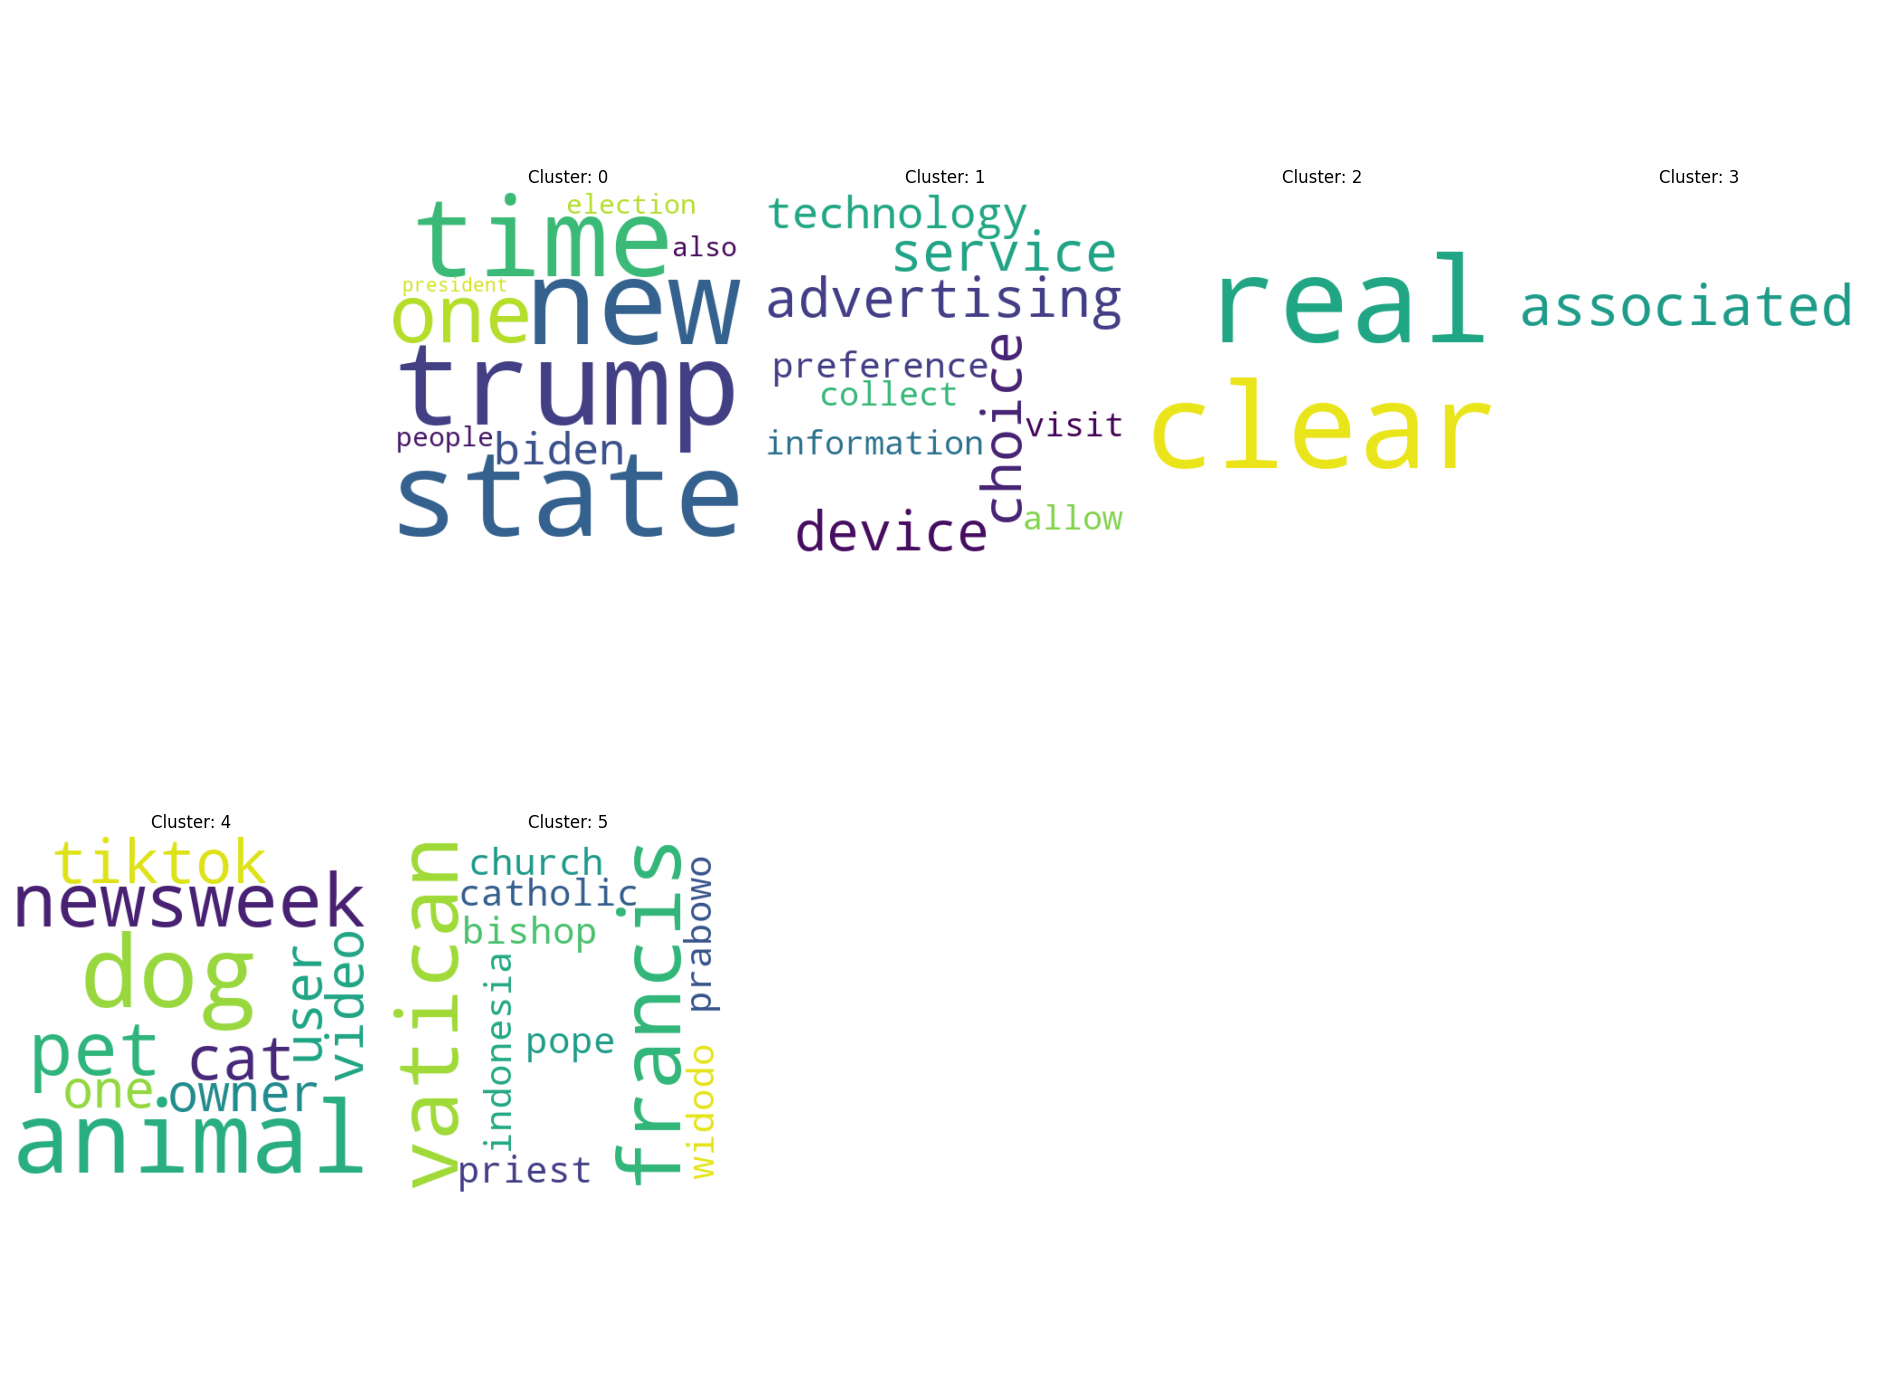

In [12]:
# [RUN THIS]
top_n = 20
top_words = {}

topic_model_i = BERTopic.load("bertopic_model_content")
# Retrieve the topic-word mappings from the BERTopic model
topic_word_mappings = topic_model_i.get_topics()

for topic_id, topic_words in topic_word_mappings.items():
    # Get the top N words for each topic (sorted by importance)
    top_words[topic_id] = [word for word, _ in topic_words[:top_n]]

num_topics = len(top_words)
num_rows = math.ceil(num_topics / 5)  # 5 columns per row
num_cols = 5

# Create the subplots grid dynamically based on the number of topics
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(19, 14))
axes = axes.flatten()  # Flatten for easier indexing

num_clusters = len(top_words)
if num_clusters == 1:  # If only 1 cluster, make `axes` iterable
    axes = [axes]

for i, (cluster_label, words) in enumerate(top_words.items()):
    # Create word frequency dictionary
    if int(cluster_label) >= 0:
        word_freqs = {word: words.count(word) for word in set(words)}
        wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(word_freqs)
        axes[i].imshow(wordcloud, interpolation="bilinear")
        axes[i].axis("off")
        axes[i].set_title(f"Cluster: {cluster_label}", fontsize=12)

# Remove unused axes 
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
axes[0].axis('off')

plt.tight_layout()
plt.show()

# topics 2 and 3 are outlier topics

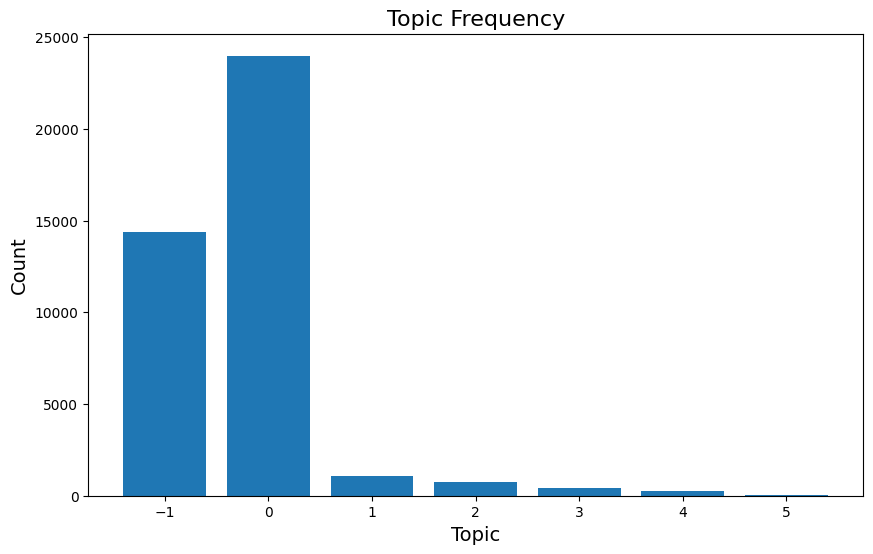

In [ ]:
# [RUN THIS]
# topic_model = BERTopic.load("bertopic_model_content")

# Count the frequency of each topic
topics_df = topic_model_i.get_topic_info()
# plot a bar chart of the topic frequency
plt.figure(figsize=(10, 6)) 
plt.bar(topics_df["Topic"], topics_df["Count"])
plt.xlabel("Topic", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Topic Frequency", fontsize=16)
plt.show()



In [ ]:
# [RUN THIS]
df_topics = df.copy()
topics, probs = topic_model_i.transform(df_topics["content_sentence"])
# df_topics["topics"] = topics
df_topics["probabilities"] = probs.tolist()
# df_topics.drop(columns=["topic_2", "topic_3"], inplace=True)
df_topics.head()

In [24]:
prob_df = pd.DataFrame(probs, columns=[f"topic_{i}" for i in range(probs.shape[1])])
df_corr = pd.concat([df_topics, prob_df], axis=1)
df_corr.head()

,outlet,article_text,content_sentence,content_words,probabilities,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
0,CBC.ca,Tij Iginla doesn't shy away from his famous la...,tij iginla shy away famous last name instead e...,"[tij, iginla, shy, away, famous, last, name, i...","[0.9496459731459796, 5.847764453173892e-18, 1....",0.949646,5.847764e-18,1.404969e-18,1.418390e-18,2.964256e-18,2.631101e-18
1,CBC.ca,This week on The Sunday Magazine with host Piy...,sunday magazine host piya chattopadhyay sunday...,"[sunday, magazine, host, piya, chattopadhyay, ...","[0.9823147722415584, 0.006640099182283699, 0.0...",0.982315,6.640099e-03,1.667710e-03,1.630533e-03,4.842256e-03,2.904627e-03
2,CBC News,An Ontario Conservative MP's use of ChatGPT to...,ontario conservative mp chatgpt share incorrec...,"[ontario, conservative, mp, chatgpt, share, in...","[0.9813410656297213, 0.006972910195100243, 0.0...",0.981341,6.972910e-03,1.748284e-03,1.705709e-03,5.119707e-03,3.112323e-03
3,CBC.ca,"When it comes to the study of sports, a man's ...",come study sport man body long considered defa...,"[come, study, sport, man, body, long, consider...","[0.9871438480654899, 0.0052718954413840625, 0....",0.987144,5.271895e-03,1.268727e-03,1.273487e-03,2.613123e-03,2.428919e-03
4,CBC.ca,"To wrap up the 48th season of Quirks & Quarks,...",wrap season quirk quark another edition listen...,"[wrap, season, quirk, quark, another, edition,...","[0.7155044842758463, 2.0167145464323668e-11, 4...",0.715504,2.016715e-11,4.917183e-12,4.834274e-12,4.598461e-11,1.203950e-11


In [16]:
df_corr.drop(columns=["topic_2", "topic_3"], inplace=True)
df_corr.head()

,outlet,article_text,content_sentence,content_words,probabilities,topic_0,topic_1,topic_4,topic_5
0,CBC.ca,Tij Iginla doesn't shy away from his famous la...,tij iginla shy away famous last name instead e...,"[tij, iginla, shy, away, famous, last, name, i...","[0.9496459731459796, 5.847764453173892e-18, 1....",0.949646,5.847764e-18,2.964256e-18,2.631101e-18
1,CBC.ca,This week on The Sunday Magazine with host Piy...,sunday magazine host piya chattopadhyay sunday...,"[sunday, magazine, host, piya, chattopadhyay, ...","[0.9823147722415584, 0.006640099182283699, 0.0...",0.982315,6.640099e-03,4.842256e-03,2.904627e-03
2,CBC News,An Ontario Conservative MP's use of ChatGPT to...,ontario conservative mp chatgpt share incorrec...,"[ontario, conservative, mp, chatgpt, share, in...","[0.9813410656297213, 0.006972910195100243, 0.0...",0.981341,6.972910e-03,5.119707e-03,3.112323e-03
3,CBC.ca,"When it comes to the study of sports, a man's ...",come study sport man body long considered defa...,"[come, study, sport, man, body, long, consider...","[0.9871438480654899, 0.0052718954413840625, 0....",0.987144,5.271895e-03,2.613123e-03,2.428919e-03
4,CBC.ca,"To wrap up the 48th season of Quirks & Quarks,...",wrap season quirk quark another edition listen...,"[wrap, season, quirk, quark, another, edition,...","[0.7155044842758463, 2.0167145464323668e-11, 4...",0.715504,2.016715e-11,4.598461e-11,1.203950e-11


In [ ]:
# get dominant topic
# Ensure only numeric columns are used for idxmax
# df_corr.drop(columns=["topic_2", "topic_3"], inplace=True)
numeric_columns = ['topic_0', 'topic_1', 'topic_4', 'topic_5']
df_corr["dominant_topic_bertopic"] = df_corr[numeric_columns].idxmax(axis=1).str.replace("topic_", "", regex=False)

df_corr.head()

,outlet,article_text,content_sentence,content_words,probabilities,topic_0,topic_1,topic_4,topic_5,dominant_topic,dominant_topic_bertopic
0,CBC.ca,Tij Iginla doesn't shy away from his famous la...,tij iginla shy away famous last name instead e...,"[tij, iginla, shy, away, famous, last, name, i...","[0.9496459731459796, 5.847764453173892e-18, 1....",0.949646,5.847764e-18,2.964256e-18,2.631101e-18,0,0
1,CBC.ca,This week on The Sunday Magazine with host Piy...,sunday magazine host piya chattopadhyay sunday...,"[sunday, magazine, host, piya, chattopadhyay, ...","[0.9823147722415584, 0.006640099182283699, 0.0...",0.982315,6.640099e-03,4.842256e-03,2.904627e-03,0,0
2,CBC News,An Ontario Conservative MP's use of ChatGPT to...,ontario conservative mp chatgpt share incorrec...,"[ontario, conservative, mp, chatgpt, share, in...","[0.9813410656297213, 0.006972910195100243, 0.0...",0.981341,6.972910e-03,5.119707e-03,3.112323e-03,0,0
3,CBC.ca,"When it comes to the study of sports, a man's ...",come study sport man body long considered defa...,"[come, study, sport, man, body, long, consider...","[0.9871438480654899, 0.0052718954413840625, 0....",0.987144,5.271895e-03,2.613123e-03,2.428919e-03,0,0
4,CBC.ca,"To wrap up the 48th season of Quirks & Quarks,...",wrap season quirk quark another edition listen...,"[wrap, season, quirk, quark, another, edition,...","[0.7155044842758463, 2.0167145464323668e-11, 4...",0.715504,2.016715e-11,4.598461e-11,1.203950e-11,0,0


In [29]:
df_corr["dominant_topic"].value_counts()

dominant_topic
topic_0    40162
topic_1      665
topic_4       63
topic_5       55
Name: count, dtype: int64

In [58]:
final_df = pd.merge(df_corr, lda_topics,on="article_text")
final_df.head()

,outlet_x,article_text,content_sentence,content_words,probabilities,topic_0,topic_1,topic_4,topic_5,dominant_topic,dominant_topic_bertopic,outlet_y,nlp_label,nlp-image_label,dominant_topic_lda
0,CBC.ca,Tij Iginla doesn't shy away from his famous la...,tij iginla shy away famous last name instead e...,"[tij, iginla, shy, away, famous, last, name, i...","[0.9496459731459796, 5.847764453173892e-18, 1....",0.949646,5.847764e-18,2.964256e-18,2.631101e-18,0,0,CBC.ca,Likely to be Bias,Likely to be Unbiased,2
1,CBC.ca,This week on The Sunday Magazine with host Piy...,sunday magazine host piya chattopadhyay sunday...,"[sunday, magazine, host, piya, chattopadhyay, ...","[0.9823147722415584, 0.006640099182283699, 0.0...",0.982315,6.640099e-03,4.842256e-03,2.904627e-03,0,0,CBC.ca,Likely to be Bias,Likely to be Unbiased,2
2,CBC News,An Ontario Conservative MP's use of ChatGPT to...,ontario conservative mp chatgpt share incorrec...,"[ontario, conservative, mp, chatgpt, share, in...","[0.9813410656297213, 0.006972910195100243, 0.0...",0.981341,6.972910e-03,5.119707e-03,3.112323e-03,0,0,CBC News,Likely to be Bias,Likely to be Bias,1
3,CBC.ca,"When it comes to the study of sports, a man's ...",come study sport man body long considered defa...,"[come, study, sport, man, body, long, consider...","[0.9871438480654899, 0.0052718954413840625, 0....",0.987144,5.271895e-03,2.613123e-03,2.428919e-03,0,0,CBC.ca,Likely to be Unbiased,Likely to be Unbiased,1
4,CBC.ca,"To wrap up the 48th season of Quirks & Quarks,...",wrap season quirk quark another edition listen...,"[wrap, season, quirk, quark, another, edition,...","[0.7155044842758463, 2.0167145464323668e-11, 4...",0.715504,2.016715e-11,4.598461e-11,1.203950e-11,0,0,CBC.ca,Likely to be Bias,Likely to be Unbiased,11


In [47]:
final_df.shape

(40945, 15)

In [60]:
final_df = final_df[["outlet_x", "article_text", "nlp_label", "nlp-image_label", "dominant_topic_bertopic", "dominant_topic_lda"]]
final_df.rename(columns={"outlet_x": "outlet"}, inplace=True)
final_df.head()

,outlet,article_text,nlp_label,nlp-image_label,dominant_topic_bertopic,dominant_topic_lda
0,CBC.ca,Tij Iginla doesn't shy away from his famous la...,Likely to be Bias,Likely to be Unbiased,0,2
1,CBC.ca,This week on The Sunday Magazine with host Piy...,Likely to be Bias,Likely to be Unbiased,0,2
2,CBC News,An Ontario Conservative MP's use of ChatGPT to...,Likely to be Bias,Likely to be Bias,0,1
3,CBC.ca,"When it comes to the study of sports, a man's ...",Likely to be Unbiased,Likely to be Unbiased,0,1
4,CBC.ca,"To wrap up the 48th season of Quirks & Quarks,...",Likely to be Bias,Likely to be Unbiased,0,11


In [57]:
final_df.to_csv("../datasets/articles_with_dominant_topic.csv", index=False)

In [ ]:
# [RUN THIS]
# Get the reduced-dimensional embeddings from the BERTopic model
embeddings = topic_model_i.transform(df['content_sentence'])[1]

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(embeddings, topics_df["Topic"])
print(f"Silhouette Score: {silhouette_avg}")